# Pima_Indians_Diabetes

### Import thư viện

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

### Import dữ liệu

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,90,60,0,0,23.5,0.191,25,0
1,2,92,52,0,0,30.1,0.141,22,0
2,11,155,76,28,150,33.3,1.353,51,1
3,3,115,66,39,140,38.1,0.150,28,0
4,1,120,80,48,200,38.9,1.162,41,0


### Exploratory Data Analysis (EDA)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               616 non-null    int64  
 1   Glucose                   616 non-null    int64  
 2   BloodPressure             616 non-null    int64  
 3   SkinThickness             616 non-null    int64  
 4   Insulin                   616 non-null    int64  
 5   BMI                       616 non-null    float64
 6   DiabetesPedigreeFunction  616 non-null    float64
 7   Age                       616 non-null    int64  
 8   Outcome                   616 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 43.4 KB


In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               152 non-null    float64 
 1   Glucose                   152 non-null    int64   
 2   BloodPressure             152 non-null    int64   
 3   SkinThickness             152 non-null    float64 
 4   Insulin                   152 non-null    float64 
 5   BMI                       152 non-null    float64 
 6   DiabetesPedigreeFunction  152 non-null    float64 
 7   Age                       152 non-null    int64   
 8   AgeGroup                  152 non-null    category
 9   BMI_Category              150 non-null    category
 10  GlucoseLevel              151 non-null    category
 11  HighGlucose               152 non-null    int32   
 12  HighBMI                   152 non-null    int32   
 13  HighAge                   152 non-null    int32   

* Ta thấy trong dataset không có dòng dữ liệu bị null hoặc nan

In [5]:
df_train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000,616.000000
mean,3.832792,120.103896,69.503247,21.073052,78.884740,31.829383,0.471456,33.147727,0.311688
std,3.406302,31.707078,18.324269,15.577851,107.405537,7.873952,0.335874,11.775236,0.463560
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.245000,24.000000,0.000000
50%,3.000000,116.000000,72.000000,23.000000,44.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,139.000000,80.000000,32.000000,127.250000,35.925000,0.607750,40.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,744.000000,67.100000,2.420000,81.000000,1.000000


Text(0.5, 0, 'Outcome')

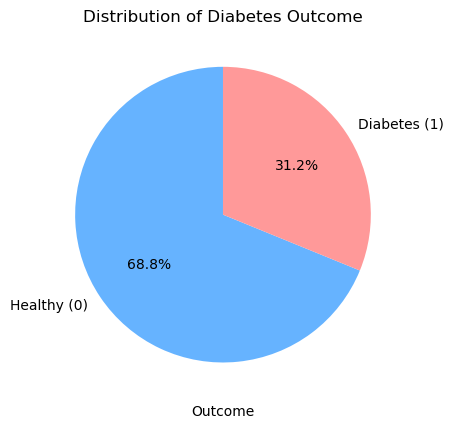

In [6]:
outcome_counts = df_train['Outcome'].value_counts()
plt.pie(outcome_counts, labels=['Healthy (0)', 'Diabetes (1)'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999']);
plt.title('Distribution of Diabetes Outcome')
plt.xlabel('Outcome')

* Trong thí nghiệm này, ta có tập dữ liệu với Outcome có 31.2% là 1 và 68.8% là 0

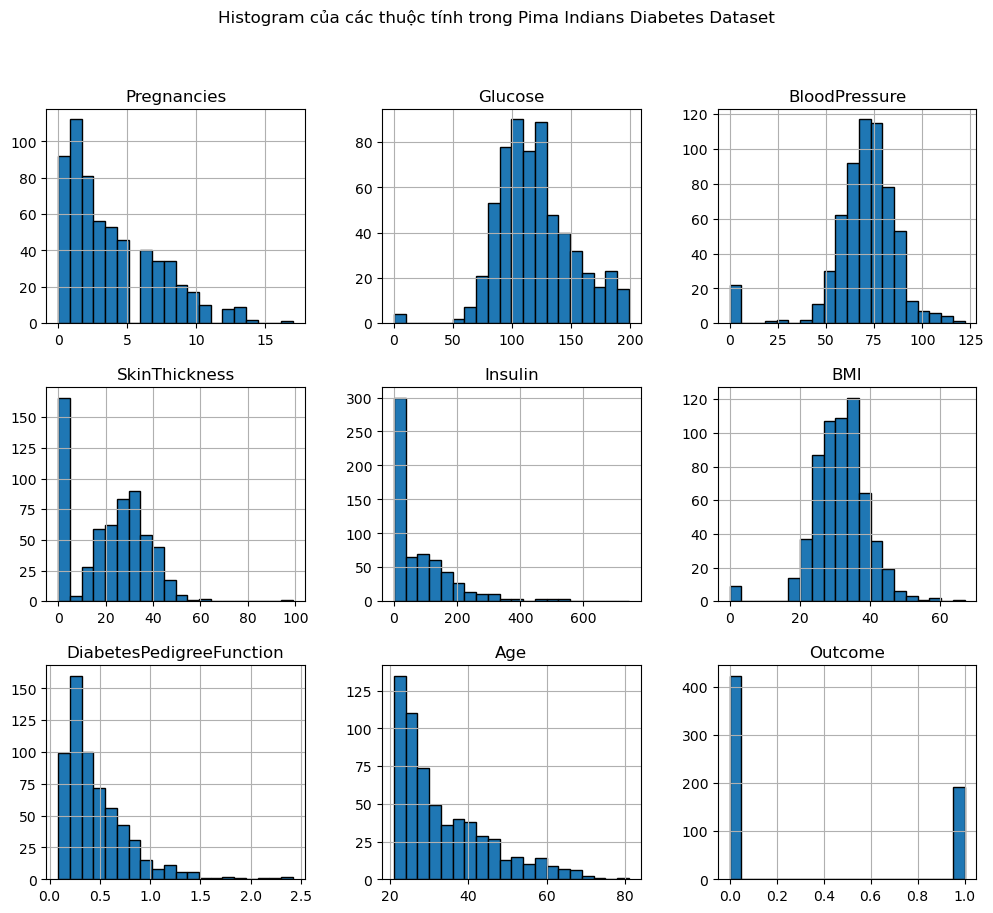

In [7]:
df_train.hist(figsize=(12, 10), bins=20, edgecolor='black')
plt.suptitle("Histogram của các thuộc tính trong Pima Indians Diabetes Dataset")
plt.show()

## Nhìn vào histogram ta có thể kết luận rằng:
* Đa số phụ nữ tham gia thí nghiệm có số lần mang thai =< 5 lần, số ít >= 10 lần và có số cực ít (outlier) > 15
* Mức glucose tập trung ở mức từ 100-130, có vài giá trị bất thường mức glucose = 0 (Đây có thể là missing values vì với mức glucose = 0 thì người thường không thể sống)
* Mức BloodPressure tập trung ở mức từ 60-80, có vài giá trị bất thưởng mức BloodPressure = 0 (Đây có thể là missing values)
* Mức SkinThickness tập trung ở mức từ 20-40, có nhiều giá trị bất thường mức SkinThickness = 0 (Đây có thể là missing values)
* Insulin có nhiều giá trị = 0 (Không thực tế), có nhiều giá trị mức insulin cực kì lớn
* Mức BMI tập trung ở mức từ 25-35, có vài giá trị bằng 0 (Không thực tế)
* Hầu hết =< 1.0 và số ít >= 2
* Số tuổi trung bình của người trong thí nghiệm từ 20-40 tuổi, số ít trên 60 tuổi
* Số người không bệnh nhiều hơn số người bị bệnh, dữ liệu không cân bằng có thể ảnh hưởng đến mô hình

## Filling missing values (zero values)
### Dựa vào histogram ta thấy rằng trong dữ liệu có quá nhiều missing value có thể dẫn đến sai sót trong quá trình phân tích dữ liệu

In [8]:
## Fill missing values của các cột bằng median của cột đó
col_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in col_with_zeros:
    median = df_train[col].replace(0, np.nan).median()   # median chỉ tính trên train
    df_train[col] = df_train[col].replace(0, np.nan).fillna(median)
    df_train[col] = df_train[col].replace(0, np.nan).fillna(median)


### Sau khi fill missing value ta tiếp tục phân tích tiếp

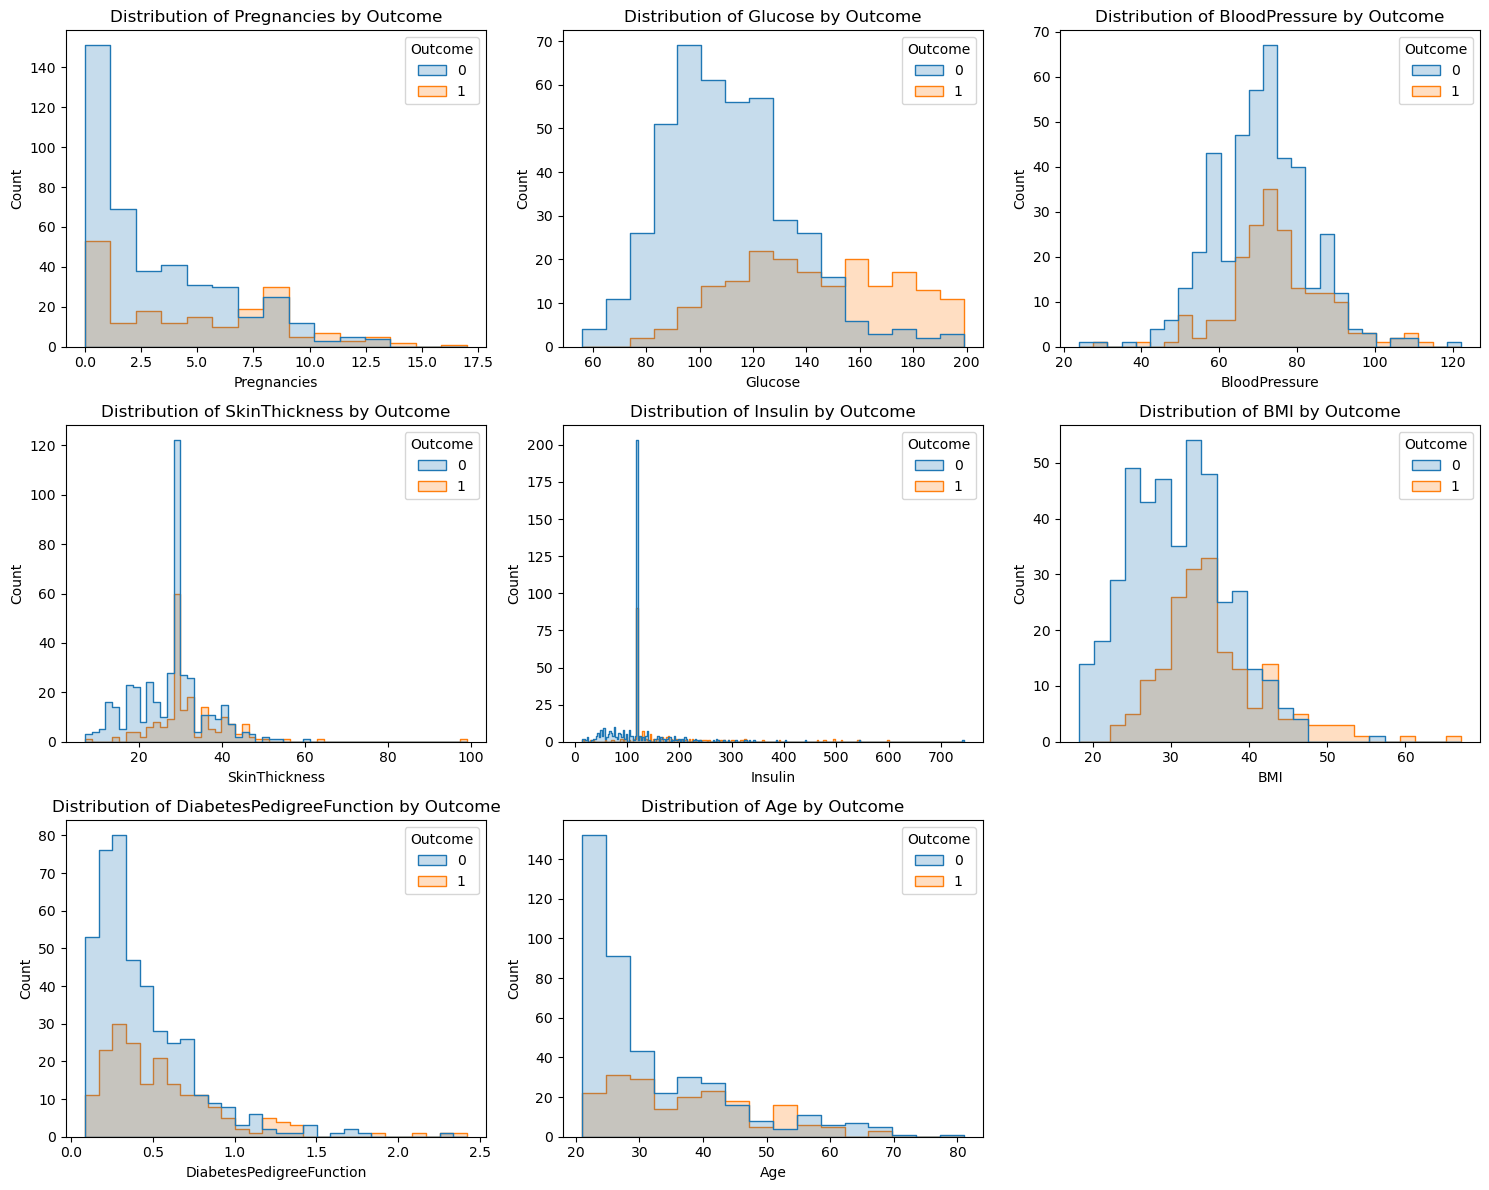

In [9]:
target = 'Outcome'
features = df_train.columns[df_train.columns != target].tolist()

def plot_feature_distributions(data, features, target):
    num_features = len(features)
    num_cols = 3
    num_rows = (num_features + num_cols - 1) // num_cols

    plt.figure(figsize=(num_cols * 5, num_rows * 4))

    for i, feature in enumerate(features):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(data=data, x=feature, hue=target, element="step", common_norm=False)
        plt.title(f'Distribution of {feature} by {target}')
        plt.xlabel(feature)
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_feature_distributions(df_train, features, target)

### Nhìn vào biểu đồ ta có thể đưa ra phân tích
* Với số lần mang thai > 5 thì ta thấy tỉ lệ mắc bệnh tiểu đường cao hơn
* Với mức glucose > 150 thì ta thấy tỉ lệ mức bệnh tiểu đường cao hơn
* Với các trường hợp BMI > 40 thì ta thấy có tỉ lệ mắc bệnh cao hơn, đều này cho thấy thể trạng béo phì cũng là nguyên nhân dẫn đến bệnh tiểu đường 
* Với các trường hợp Insulin cao > 150 thì đa số đều mắc phải bệnh tiểu đường, mặc dù đã fill các missing value nhưng vẫn còn các trường hợp có mức insulin = 0 và đa số đều mắc bệnh
* Với DiabetesPredigreeFunction thì ta thấy ở mức > 1 thì đa số đều mắc bệnh, cho thấy bệnh tiểu đường cũng có thể di truyền
* Với BloodPressure > 100 thì khả năng mắc bệnh cao
* Với các trường hợp có tuổi > 40 thì tỉ lệ mắc bệnh khá cao

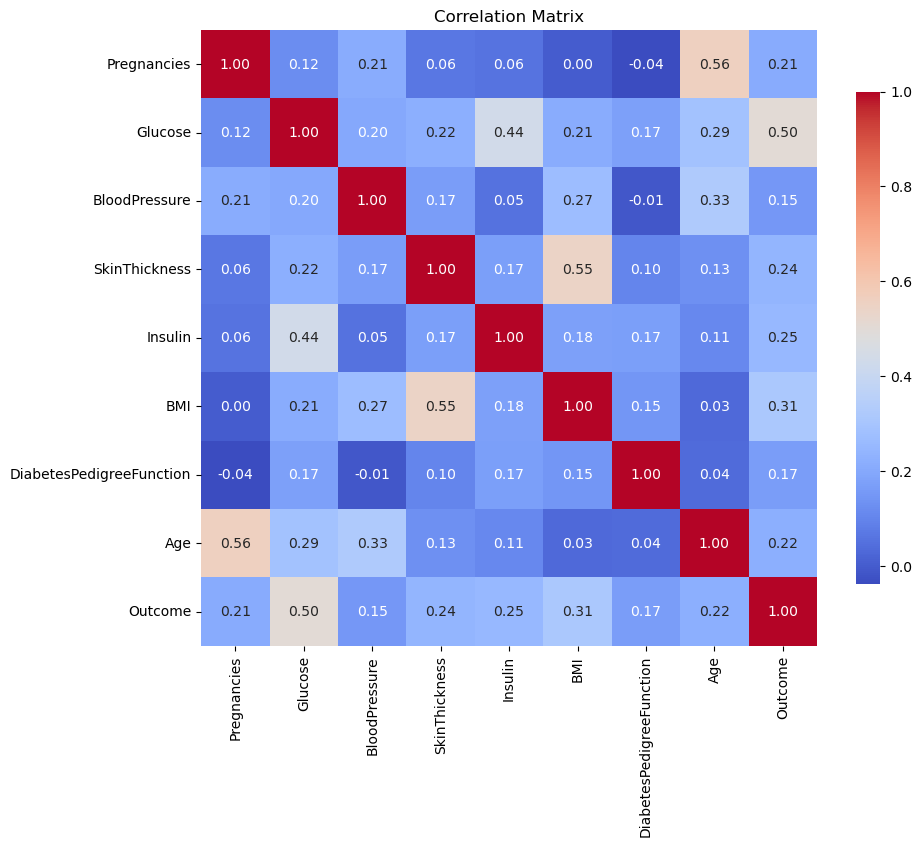

In [10]:
corr = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()

### Nhận xét:
* Dựa vào biểu đồ HeatMap ta thấy được các biến tương quan với Outcome:
    - Glucose tương quan mạnh nhất với Outcome với 0.5 cho thấy người có mức glucose cao có tỉ lệ mắc cao
    - BMI tương quan với Outcome, cho thấy người có BMI cao dễ bị mắc bệnh
    - Insulin tương quan với Outcome, đây là một yếu tố cũng góp phần không nhỏ vào tỉ lệ mắc bệnh
    - SkinThickness tương quan với Outcome, cho thấy người có da dày cũng có tỉ lệ mắc bệnh cao hơn
    - Age cũng tương quan trung bình với Outcome, cho thấy người cao tuổi cũng dễ bệnh
    - Pregnancies cũng tương quan trung bình với Outcome, cho số lần mang thai càng nhiều thì tỉ lệ mắc càng lớn
    - DiabetesPedigreeFunction cũng tương quan nhẹ với Outcome, cho di truyền cũng góp phần vào tỉ lệ mắc bệnh nhưng không quá mạnh
    - BloodPressure cũng tương quan yếu với Outcome, cho thấy một số người gặp vấn đề về huyết áp cao cũng có thể có tỉ lệ mắc phải bệnh tiểu đường
* Các cặp biến tương quan mạnh:
    - Age tương quan mạnh với Pregnancies với 0.56, điều này khá dễ hiểu các người phụ nữ tuổi càng cao thì thường có số lần mang thai nhiều hơn
    - Glucose tương quan mạnh với Insulin với 0.44, điều này cho thấy mức Glucose liên quan đến mức Insulin trong cơ thể
    - SkinThickness tương quan mạnh với BMI với 0.55, khá dễ hiểu vì người có BMI cao thường có lớp da dày hơn
    - BMI tương quan với BloodPressure với 0.27, cho thấy người có chỉ số BMI cao có thể mắc đến chứng tăng huyết áp

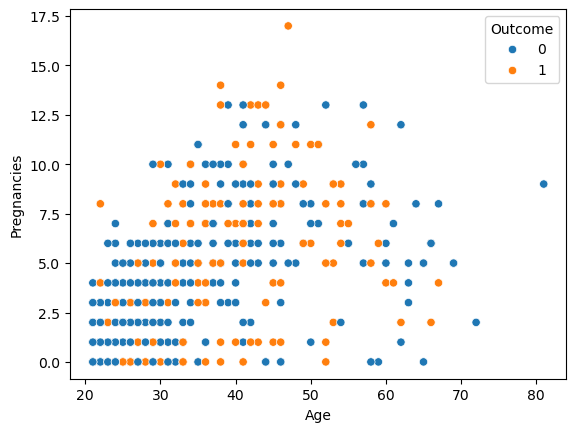

In [11]:
sns.scatterplot(data=df_train, x='Age', y='Pregnancies', hue='Outcome');

### Nhận xét:
* Khi Age tăng thì Pregnancies có xu hương tăng nhẹ
* Các người trẻ, mang thai ít có tỉ lệ bệnh thấp hơn với người lớn tuổi mang thai nhiều

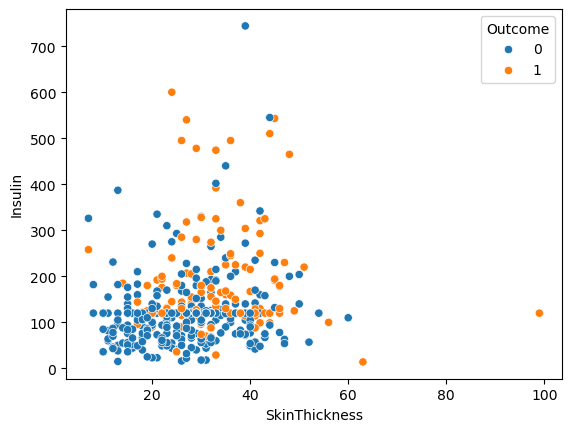

In [12]:
sns.scatterplot(data=df_train, x='SkinThickness', y='Insulin', hue='Outcome');

## Nhận xét:
* Đối với nhóm người có Insulin < 150 và SkinThickness < 30 có tỉ lệ bệnh thấp 
* Khi SkinThickness tăng thì Insulin cũng có xu hướng tăng cao nhưng không quá nhiều

<Axes: xlabel='SkinThickness', ylabel='BMI'>

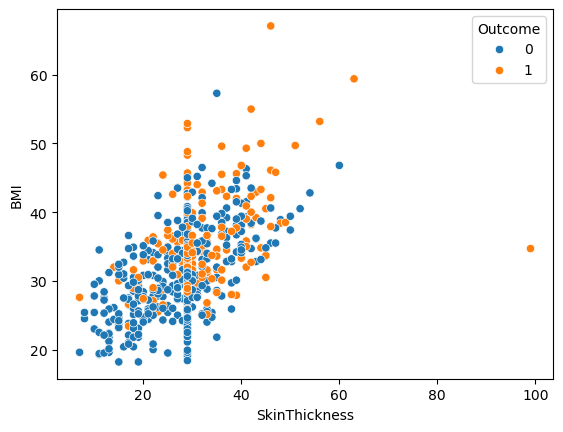

In [13]:
sns.scatterplot(data=df_train, x='SkinThickness', y='BMI', hue='Outcome')

### Nhận xét:
* Ta thấy BMI càng cao thì SkinThickness càng cao
* Trong khoảng BMI <= 30 thì tỉ lệ người mắc bệnh thấp, BMI càng tăng thì tỉ lệ mắc bệnh càng tăng

<Axes: xlabel='Glucose', ylabel='Insulin'>

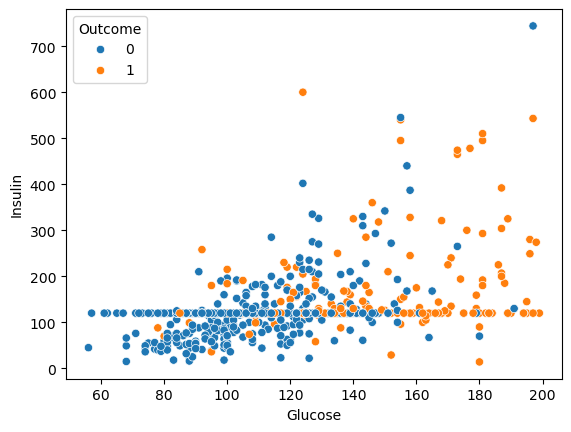

In [14]:
sns.scatterplot(data=df_train, x='Glucose', y='Insulin', hue='Outcome')

### Nhận xét:
* Glucose càng cao thì Insulin càng cao, cao nhất là > 800
* Mức glucose < 125 có tỉ lệ mắc bệnh thấp, mức glucose cao hơn thì tỉ lệ mắc bệnh cao hơn

## Tổng kết
* Ta có các feature khá mạnh dùng để dự đoán như: Glucose, BMI, Age, Insulin, SkinThickness, Pregnancies
* Các feature còn lại dù không quá tương quan nhưng vẫn là các thành phần quan trọng trong dataset


## Feature engineering

In [15]:
## Nhóm các cột quan trọng thành cột mới
df_train['AgeGroup'] = pd.cut(df_train['Age'], 
                             bins=[20, 30, 40, 50, 60, 100],
                             labels=['20s', '30s', '40s', '50s', '60+'])

df_train['BMI_Category'] = pd.cut(df_train['BMI'], 
                                 bins=[0, 18.5, 25, 30, 100],
                                 labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

df_train['GlucoseLevel'] = pd.cut(df_train['Glucose'], 
                                 bins=[0, 99, 125, 200],
                                 labels=['Normal', 'Prediabetic', 'Diabdetic'])

df_test['AgeGroup'] = pd.cut(df_test['Age'], 
                             bins=[20, 30, 40, 50, 60, 100],
                             labels=['20s', '30s', '40s', '50s', '60+'])
df_test['BMI_Category'] = pd.cut(df_test['BMI'], 
                                 bins=[0, 18.5, 25, 30, 100],
                                 labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df_test['GlucoseLevel'] = pd.cut(df_test['Glucose'], 
                                 bins=[0, 99, 125, 200],
                                    labels=['Normal', 'Prediabetic', 'Diabdetic'])

## Tạo các cột mới dánh dấu rủi ro mắc bệnh cao
df_train['HighGlucose'] = (df_train['Glucose'] > 125).astype(int)
df_train['HighBMI'] = (df_train['BMI'] >= 30).astype(int)
df_train['HighAge'] = (df_train['Age'] >= 50).astype(int)
df_train['HighBloodPressure'] = (df_train['BloodPressure'] >= 80).astype(int)
df_train['HighPregnancies'] = (df_train['Pregnancies'] >= 5).astype(int)

df_test['HighGlucose'] = (df_test['Glucose'] > 125).astype(int)
df_test['HighBMI'] = (df_test['BMI'] >= 30).astype(int)
df_test['HighAge'] = (df_test['Age'] >= 50).astype(int)
df_test['HighBloodPressure'] = (df_test['BloodPressure'] >= 80).astype(int)
df_test['HighPregnancies'] = (df_test['Pregnancies'] >= 5).astype(int)

df_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeGroup,BMI_Category,GlucoseLevel,HighGlucose,HighBMI,HighAge,HighBloodPressure,HighPregnancies
0,2,90.0,60.0,29.0,120.0,23.5,0.191,25,0,20s,Normal,Normal,0,0,0,0,0
1,2,92.0,52.0,29.0,120.0,30.1,0.141,22,0,20s,Obese,Normal,0,1,0,0,0
2,11,155.0,76.0,28.0,150.0,33.3,1.353,51,1,50s,Obese,Diabdetic,1,1,1,0,1
3,3,115.0,66.0,39.0,140.0,38.1,0.150,28,0,20s,Obese,Prediabetic,0,1,0,0,0
4,1,120.0,80.0,48.0,200.0,38.9,1.162,41,0,40s,Obese,Prediabetic,0,1,0,1,0


## Prepocessing

In [16]:

## log transform các cột có phân phối lệch

df_train['Insulin'] = np.log1p(df_train['Insulin'])
df_train['Pregnancies'] = np.log1p(df_train['Pregnancies'])
df_train['SkinThickness'] = np.log1p(df_train['SkinThickness'])
df_train['DiabetesPedigreeFunction'] = np.log1p(df_train['DiabetesPedigreeFunction'])

df_test['Insulin'] = np.log1p(df_test['Insulin'])
df_test['Pregnancies'] = np.log1p(df_test['Pregnancies'])
df_test['SkinThickness'] = np.log1p(df_test['SkinThickness'])
df_test['DiabetesPedigreeFunction'] = np.log1p(df_test['DiabetesPedigreeFunction'])

## Xác định các cột số và cột phân loại
numeric_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

categorical_features = ['AgeGroup', 'BMI_Category', 'GlucoseLevel', 
                        'HighGlucose', 'HighBMI', 'HighAge', 'HighBloodPressure', 'HighPregnancies']

# Split dữ liệu thành train và test
X = df_train.drop('Outcome', axis=1)
y = df_train['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tạo pipeline tiền xử lý
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),       
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])




## Model training

In [ ]:
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=1000,random_state=42))
    ]),
    'KNeighborsClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=5))
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(max_depth=5, random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(n_estimators=100,max_depth=None,random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(n_estimators=100))
    ])
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4),
        'ROC_AUC': round(roc_auc, 4),
        'Accuracy trên tập train': round(model.score(X_train, y_train),4),
        'Accuracy trên tập test': round(model.score(X_test, y_test),4)
    })


results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print(results_df)

                  Model  Accuracy  Precision  Recall  F1 Score  ROC_AUC  \
3         Random Forest    0.7903     0.7241  0.5385    0.6176   0.7222   
0   Logistic Regression    0.7742     0.6774  0.5385    0.6000   0.7104   
1  KNeighborsClassifier    0.7661     0.6562  0.5385    0.5915   0.7045   
4               XGBoost    0.7661     0.6389  0.5897    0.6133   0.7184   
2         Decision Tree    0.7339     0.6250  0.3846    0.4762   0.6394   

   Accuracy trên tập train  Accuracy trên tập test  
3                   1.0000                  0.7903  
0                   0.8110                  0.7742  
1                   0.8455                  0.7661  
4                   1.0000                  0.7661  
2                   0.8496                  0.7339  


### Nhận xét:
* RandomForest có thể đang fit tốt với dataset vì mọi chỉ số đang là cao nhất, có thể đem đi tuning kết quả tốt hơn
* KNN hiệu quả gần với RF cho hiệu suất tốt, đem đi tuning để có kết quả tốt hơn
* XGBoost cho ra recall tốt nhưng precision thấp, đem đi tuning có thể cho ra kết quả tốt hơn
* LogisticRegression cho ra kết quả tốt
* DecisionTree có recall và F1 thấp với mặt bằng chung, không tổng quát tốt và bị overfit

## Hyperparameter tuning

In [18]:
models_params = [
    (
        Pipeline([
            ('preprocessor', preprocessor),
            ('model', RandomForestClassifier(random_state=42))
        ]),
        {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [5, 10, 15, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__max_features': ['sqrt', 'log2']
        },
        'Random Forest'
    ),

    (
        Pipeline([
            ('preprocessor', preprocessor),
            ('model', XGBClassifier(
                use_label_encoder=False,
                eval_metric='logloss',
                random_state=42
            ))
        ]),
        {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.7, 0.9, 1.0],
            'model__colsample_bytree': [0.7, 0.9, 1.0],
            'model__gamma': [0, 0.1, 0.3]
        },
        'XGBoost'
    ),

    (
        Pipeline([
            ('preprocessor', preprocessor),
            ('model', KNeighborsClassifier())
        ]),
        {
            'model__n_neighbors': [3, 5, 7, 9, 11],
            'model__weights': ['uniform', 'distance'],
            'model__p': [1, 2] 
        },
        'KNN'
    ),
    (
        Pipeline([
            ('preprocessor', preprocessor),
            ('model', LogisticRegression())
        ]),
        {
             'model__penalty': ['l1', 'l2'],
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__solver': ['liblinear', 'saga']
        },
        'Logistic Regression'
    )
]

for model, params, name in models_params:
    print(f"\nTuning {name}...")
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best accuracy: {grid.best_score_:.4f}")


Tuning Random Forest...
Best params for Random Forest: {'model__max_depth': 5, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best accuracy: 0.7907

Tuning XGBoost...
Best params for XGBoost: {'model__colsample_bytree': 0.9, 'model__gamma': 0.3, 'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__subsample': 0.7}
Best accuracy: 0.7988

Tuning KNN...
Best params for KNN: {'model__n_neighbors': 11, 'model__p': 2, 'model__weights': 'distance'}
Best accuracy: 0.7541

Tuning Logistic Regression...
Best params for Logistic Regression: {'model__C': 0.1, 'model__penalty': 'l1', 'model__solver': 'saga'}
Best accuracy: 0.7927


### Sau khi tuning 4 model ta có kết quả:
* XGBoost cho ra best accuracy cao nhất, cho thấy model này rất mạnh trên data Pima
* Logicstic Regression cho ra best accuracy cao gần như tương đương XGB
* RandomForest cho ra hiệu suất tốt với best accuracy
* KNN cho ra hiệu suất yếu hơn hẳn 3 model trên 

In [ ]:
best_models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(
            C=0.1,
            penalty='l1',
            solver='liblinear'
        ))
    ]),
    'Ramdom Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(
            max_features='sqrt',
            n_estimators=300,
            max_depth=None,
            min_samples_split=10,
            min_samples_leaf=1
        ))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBClassifier(
            colsample_bytree=1.0,
            gamma=0.3,
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.7
        ))
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(
            n_neighbors=11,
            weights='uniform',
            p=2
        ))
    ])
}

for name, model in best_models.items():
    model.fit(X, y)
    y_pred = model.predict(df_test)

    submission = pd.DataFrame({
        'id': df_test.index,
        'Outcome': y_pred
    })
    submission.to_csv(f'./submission/{name.replace(" ", "_").lower()}submission.csv', index=False)
    print(f'Đã tạp file {name} submission.')

Đã tạp file Logistic Regression submission.
Đã tạp file Ramdom Forest submission.
Đã tạp file XGBoost submission.
Đã tạp file KNN submission.


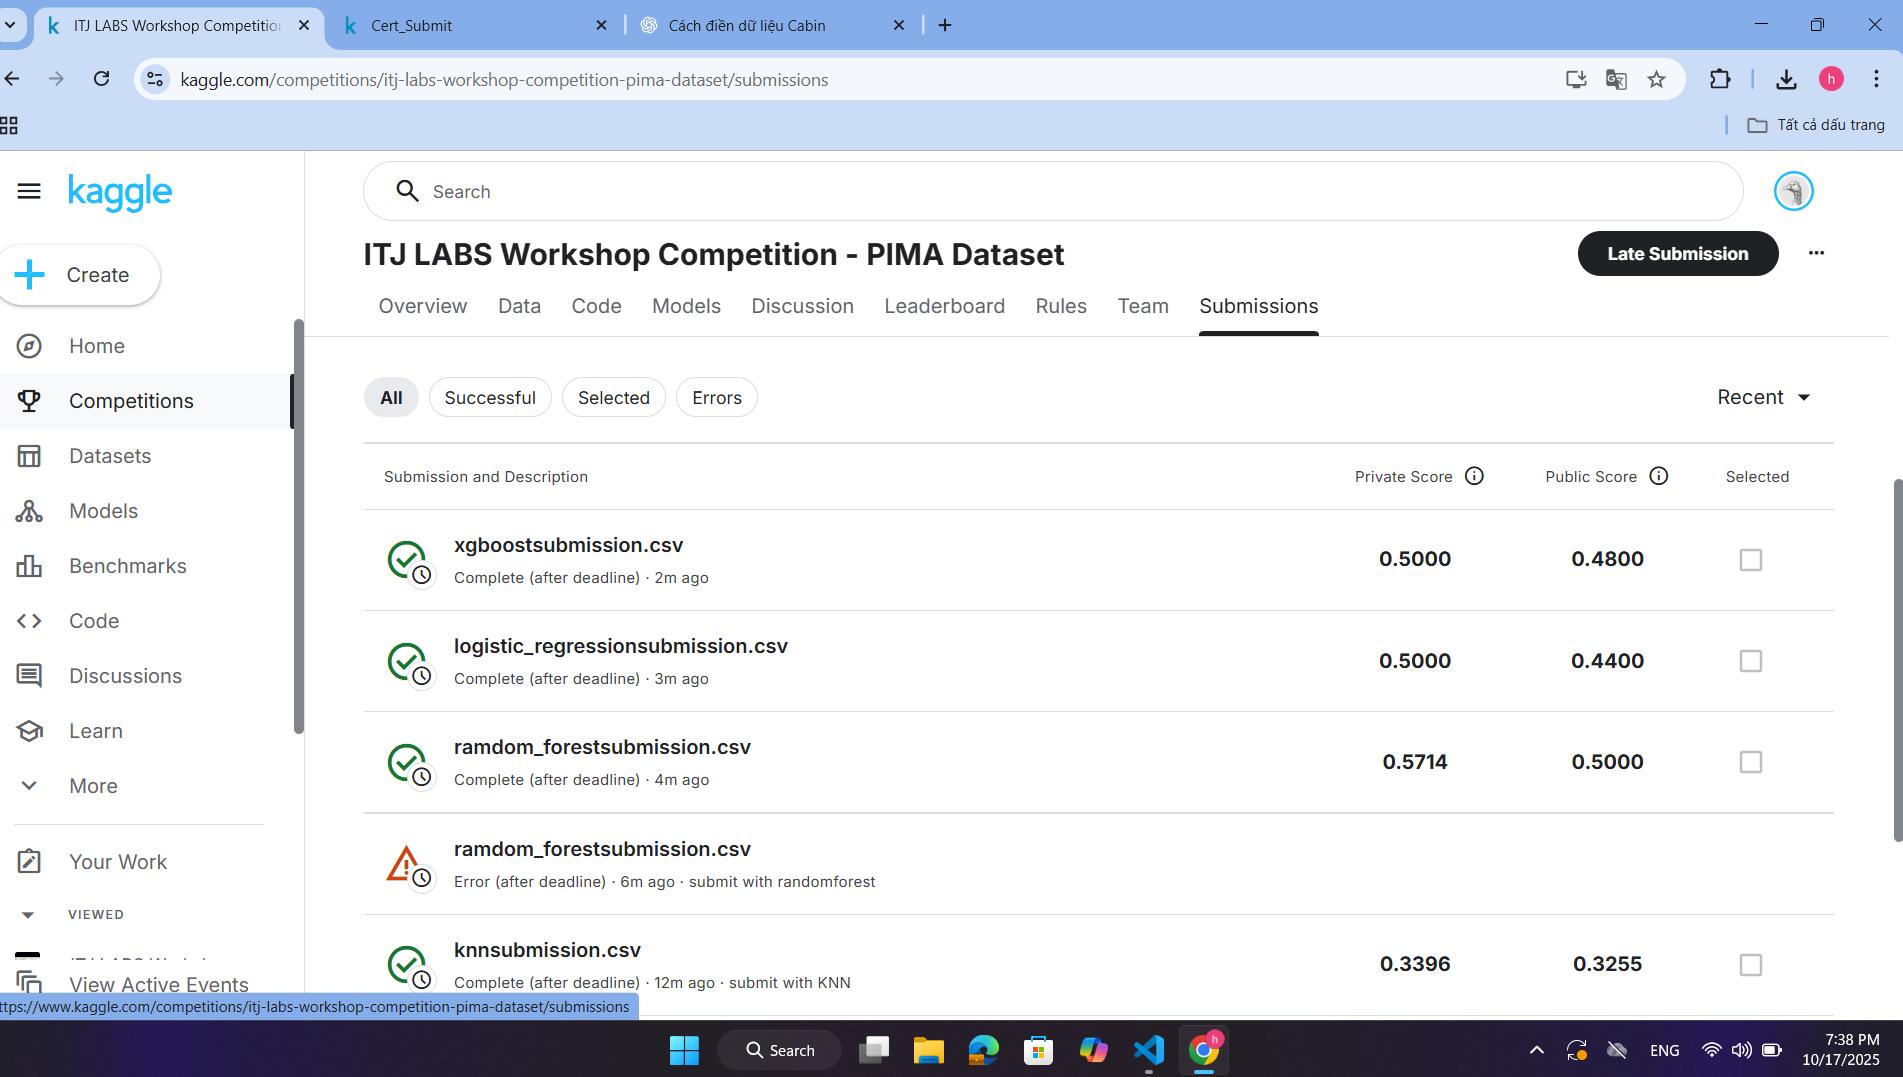

In [21]:
from IPython.display import Image, display

display(Image(filename='./images/minhchung.png'))